In [310]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [425]:
np.random.seed(1600134)

# Time Series Generation

In [426]:
T = 2000
y_t = np.zeros(2000)
y_t[0] = 100 
y_t[1] = 100
e_t = np.random.standard_normal(size = T)

In [427]:
%matplotlib inline
phi = 0.6
d = 0.025
theta = -0.4 
for i in range(2,2000):
    dy_ = y_t[i-1] - y_t[i-2]
    dy = 0.6*(dy_ - d) + e_t[i] + theta*e_t[i-1]
    y_t[i] = y_t[i-1] + dy

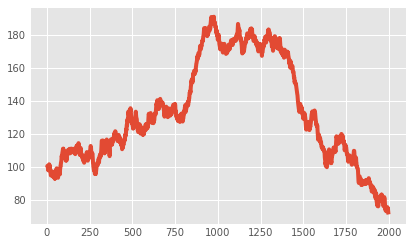

In [428]:
plt.plot(y_t)

In [429]:
X_train, X_test = y_t[:1400], y_t[len(y_t) - 600:]

# Trading Strategies

I am going to look at the following strategies: buy and hold, trend-following and mean-reversion. 

In [430]:
def log_returns(TV):
    returns = [0]
    for i in range(1,len(TV)):
        r = np.log(TV[i]/TV[i-1])
        returns.append(r)
    return returns

In [554]:
def sharpe_ratio(returns):
    returns=np.array(returns)
    avg_return = returns.mean()
    std = returns.std()
    return avg_return*np.sqrt(252)/std

In [555]:
cash = np.zeros(np.shape(y_t))
cash[0] = 10000

### Buy and hold

I will be using this as a benchmark against our 3 trading strategies.

In [556]:
TV_bh = cash[0]*y_t/y_t[0]

# Finding the optimal window length



In [557]:
def mean_rev(window, data):
    t = np.linspace(0, len(data), len(data))
    time_window = window
    cumsum = [0]

    ma = np.zeros(np.shape(data))

    w = np.zeros(np.shape(data))
    cash = np.zeros(np.shape(data))

    cash[0] = 10000

    for i, x in enumerate(data[:-1], 0):
        cumsum.append(cumsum[i] + x)
        ma[i] = x
        if i>=time_window:
            moving_ave = (cumsum[i] - cumsum[i-time_window])/(time_window)
            ma[i] = moving_ave

        if ma[i] == x:
            w[i+1] = w[i]
            cash[i+1] = cash[i]

        if ma[i] > x: 
            w[i+1] = cash[i]/x  + w[i]
            cash[i+1] = 0

        if ma[i] < x:
            cash[i+1] = w[i]*x + cash[i]
            w[i+1] = 0

    ma[i+1] = data[len(data)-1]

    mr_strategy = [a*b for a,b in zip(w,data)]+ cash
    returns = log_returns(mr_strategy)
    sharpe = sharpe_ratio(returns)
    return mr_strategy, sharpe


In [558]:
def trend_f(window, data):
    t = np.linspace(0, len(data), len(data))
    time_window = window
    cumsum = [0]

    ma = np.zeros(np.shape(data))

    w = np.zeros(np.shape(data))
    cash = np.zeros(np.shape(data))

    cash[0] = 10000

    for i, x in enumerate(data[:-1], 0):
        cumsum.append(cumsum[i] + x)
        ma[i] = x
        if i>=time_window:
            moving_ave = (cumsum[i] - cumsum[i-time_window])/(time_window)
            ma[i] = moving_ave

        if ma[i] == x:
            w[i+1] = w[i]
            cash[i+1] = cash[i]

        if ma[i] < x: 
            w[i+1] = cash[i]/x  + w[i]
            cash[i+1] = 0

        if ma[i] > x:
            cash[i+1] = w[i]*x + cash[i]
            w[i+1] = 0

    ma[i+1] = data[len(data)-1]

    tf_strategy = [a*b for a,b in zip(w,data)]+ cash
    returns = log_returns(tf_strategy)
    sharpe = sharpe_ratio(returns)
    return tf_strategy, sharpe
    



In [559]:
def dual_cv(long_w, short_w, data):
    X_train=data
    cumsum = [0]
    flag=-1

    long_ma = np.zeros(np.shape(X_train))
    short_ma = np.zeros(np.shape(X_train)
                       )
    w = np.zeros(np.shape(X_train))
    cash = np.zeros(np.shape(X_train))

    cash[0] = 10000

    for i, x in enumerate(X_train[:-1], 0):
        cumsum.append(cumsum[i] + x)
        long_ma[i] = x
        short_ma[i] = x
        if i>=long_w:
            long_moving_ave = (cumsum[i] - cumsum[i-long_w])/(long_w)
            short_moving_ave = (cumsum[i] - cumsum[i-short_w])/(short_w)
            long_ma[i] = long_moving_ave
            short_ma[i] = short_moving_ave

        if flag == -1:
            if short_ma[i] > long_ma[i]:
                flag = 1
                w[i+1] = cash[i]/x + w[i]
                cash[i+1] = 0
            elif short_ma[i] < long_ma[i]:
                flag = 0
                cash[i+1] = w[i]*x + cash[i]
                w[i+1] = 0
            else:
                w[i+1] = w[i]
                cash[i+1] = cash[i]
        elif flag == 0:
            if short_ma[i] > long_ma[i]:
                flag = 1
                w[i+1] = cash[i]/x + w[i]
                cash[i+1] = 0
            else:
                w[i+1] = w[i]
                cash[i+1] = cash[i]
        else:
            if short_ma[i] < long_ma[i]:
                flag = 0
                cash[i+1] = w[i]*x + cash[i]
                w[i+1] = 0
            else:
                w[i+1] = w[i]
                cash[i+1] = cash[i]

    long_ma[i+1] = X_train[len(X_train)-1]
    short_ma[i+1] = X_train[len(X_train)-1]

    dma_cv_strategy = [a*b for a,b in zip(w,X_train)]+ cash
    returns = log_returns(dma_cv_strategy)
    sharpe = sharpe_ratio(returns)
    return sharpe

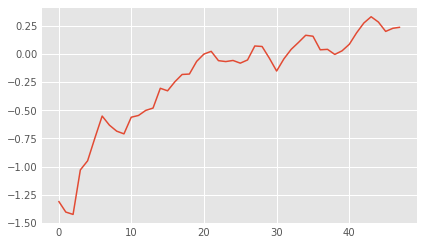

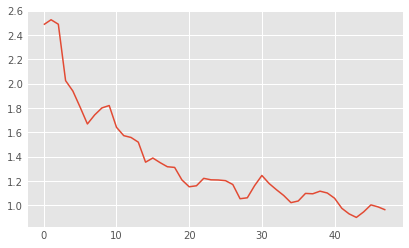

In [560]:
mr_sharpe = []
mr_max = 0
mr_optim = 0
for i in range(2,50):
    strat,mr = mean_rev(i, X_train)
    mr_sharpe.append(mr)
    if mr > mr_max:
        mr_max = mr
        mr_optim = i
        
plt.plot(mr_sharpe)
plt.show()

tf_max = 0
tf_optim = 0
tf_sharpe = []
for i in range(2,50):
    strat, tf = trend_f(i, X_train)
    tf_sharpe.append(tf)
    if tf > tf_max:
        tf_max = tf
        tf_optim = i
    
plt.plot(tf_sharpe)
plt.show()

dma_sharpe_max = 0
dma_long = 0
dma_short = 0
for i in range(30,101):
    for k in range(2,21):
        dma = dual_cv(i, k, X_train)
        if dma > dma_sharpe_max:
            dma_long = i
            dma_short = k

In [561]:
print(dma_long)
print(dma_short)
print(tf_optim)
print(mr_optim)

100
20
3
45


## Optimal Window Sizes

Trend following - 4
Mean Reversion - 45
Dual Cross Over - 750,30

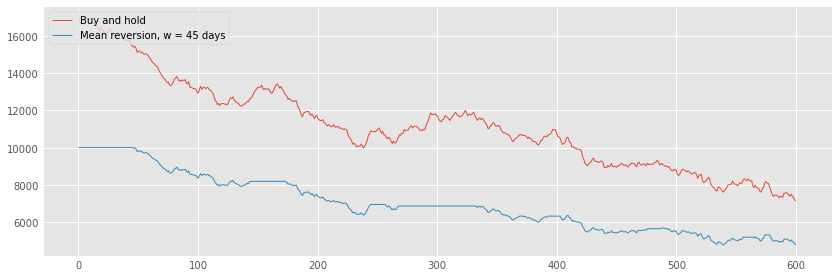

In [562]:
#TRADING: MEAN REVERSION 
t = np.linspace(0, len(X_test), len(X_test))
time_window = 45
cumsum = [0]

ma = np.zeros(np.shape(X_test))

w = np.zeros(np.shape(X_test))
cash = np.zeros(np.shape(X_test))

cash[0] = 10000

for i, x in enumerate(X_test[:-1], 0):
    cumsum.append(cumsum[i] + x)
    ma[i] = x
    if i>=time_window:
        moving_ave = (cumsum[i] - cumsum[i-time_window])/(time_window)
        ma[i] = moving_ave
    
    if ma[i] == x:
        w[i+1] = w[i]
        cash[i+1] = cash[i]
        
    if ma[i] > x: 
        w[i+1] = cash[i]/x  + w[i]
        cash[i+1] = 0
        
    if ma[i] < x:
        cash[i+1] = w[i]*x + cash[i]
        w[i+1] = 0

ma[i+1] = X_test[len(X_test)-1]

mr_strategy = [a*b for a,b in zip(w,X_test)]+ cash

plt.figure(figsize=(12.6,4.6))
plt.plot(t,TV_bh[1400:], label = "Buy and hold", linewidth=1)
plt.plot(t, mr_strategy, label="Mean reversion, w = {0} days".format(time_window), linewidth=1)
plt.legend(loc="upper left")
plt.show()

## Strategy 2: Trend Following

In [494]:
#TRADING: TREND FOLLOWING 
    
time_window = 4
cumsum = [0]

ma = np.zeros(np.shape(X_test))

w = np.zeros(np.shape(X_test))
cash = np.zeros(np.shape(X_test))

cash[0] = 10000
                
for i, x in enumerate(X_test[:-1], 0):
    cumsum.append(cumsum[i] + x)
    ma[i] = x
    if i>=time_window:
        moving_ave = (cumsum[i] - cumsum[i-time_window])/(time_window)
        ma[i] = moving_ave
    
    if ma[i] == x:
        w[i+1] = w[i]
        cash[i+1] = cash[i]
    
    if ma[i] < x: 
        w[i+1] = cash[i]/x  + w[i]
        cash[i+1] = 0
        
    if ma[i] > x:
        cash[i+1] = w[i]*x + cash[i]
        w[i+1] = 0

ma[i+1] = X_test[len(X_test)-1]
        
tf_strategy = [a*b for a,b in zip(w,X_test)]+ cash

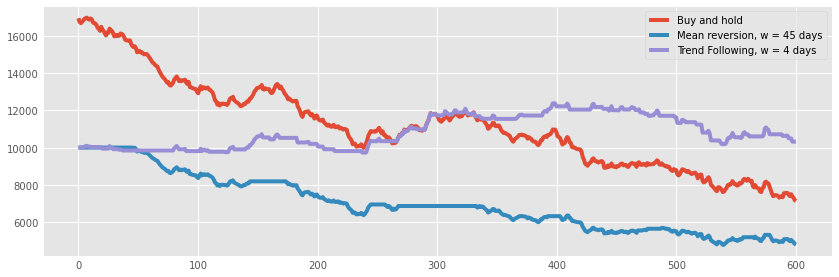

In [495]:
plt.figure(figsize=(12.6,4.6))
plt.plot(t, TV_bh[1400:], label = "Buy and hold")
plt.plot(t, mr_strategy, label="Mean reversion, w = 45 days")
plt.plot(t, tf_strategy, label="Trend Following, w = 4 days")
plt.legend(loc="upper right")
plt.show()

## Strategy 3 : Dual moving average crossover

In this model we look to compare a longer-term moving average to a shorter-term moving average.  When there is a cross over between the moving averages, we either buy or sell.  Specifically, when the shorter term moving average goes above the longer term moving average, we buy.  When the shorter term moving average goes below the longer term moving average, we sell. 

In [517]:
def dual_mcv_sig(long, short, data):
    long_w = long
    short_w = short
    X_test=data
    flag = - 1
    sigPriceBuy = []
    sigPriceSell = []
    cumsum = [0]

    long_ma = np.zeros(np.shape(X_test))
    short_ma = np.zeros(np.shape(X_test))
    w = np.zeros(np.shape(X_test))
    cash = np.zeros(np.shape(X_test))

    cash[0] = 10000

    for i, x in enumerate(X_test[:-1], 0):
        cumsum.append(cumsum[i] + x)
        long_ma[i] = x
        short_ma[i] = x
        if i>=long_w:
            long_moving_ave = (cumsum[i] - cumsum[i-long_w])/(long_w)
            short_moving_ave = (cumsum[i] - cumsum[i-short_w])/(short_w)
            long_ma[i] = long_moving_ave
            short_ma[i] = short_moving_ave

        if flag == -1:
            if short_ma[i] > long_ma[i]:
                flag = 1
                w[i+1] = cash[i]/x + w[i]
                cash[i+1] = 0
                sigPriceSell.append(np.nan)
                sigPriceBuy.append(np.nan)
            elif short_ma[i] < long_ma[i]:
                flag = 0
                cash[i+1] = w[i]*x + cash[i]
                w[i+1] = 0
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)
            else:
                w[i+1] = w[i]
                cash[i+1] = cash[i]
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)
        elif flag == 0:
            if short_ma[i] > long_ma[i]:
                flag = 1
                w[i+1] = cash[i]/x + w[i]
                cash[i+1] = 0
                sigPriceSell.append(np.nan)
                sigPriceBuy.append(x)
            else:
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)
                w[i+1] = w[i]
                cash[i+1] = cash[i]
        else:
            if short_ma[i] < long_ma[i]:
                flag = 0
                cash[i+1] = w[i]*x + cash[i]
                w[i+1] = 0
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(x)
            else:
                w[i+1] = w[i]
                cash[i+1] = cash[i]
                sigPriceBuy.append(np.nan)
                sigPriceSell.append(np.nan)


    long_ma[i+1] = X_test[len(X_test)-1]
    short_ma[i+1] = X_test[len(X_test)-1]
    sigPriceBuy.append(np.nan)
    sigPriceSell.append(np.nan)

    dma_cv_strategy = [a*b for a,b in zip(w,X_test)]+ cash

    return long_ma, short_ma, sigPriceBuy, sigPriceSell, dma_cv_strategy

## Returns for train and test

### Train

In [566]:
t = np.linspace(0, len(X_train), len(X_train))
mr_train, mr_train_sharpe = mean_rev(mr_optim, X_train)
tf_train, tf_train_sharpe = trend_f(tf_optim, X_train)
long_ma_train, short_ma_train, sigPriceBuy_train, sigPriceSell_train, dma_train = dual_mcv_sig(100,20,X_train)

In [567]:
returns_bh_train = log_returns(TV_bh[:1400])
returns_tf_train = log_returns(tf_train)
returns_mr_train = log_returns(mr_train)
returns_dma_train = log_returns(dma_train)

### Test

In [568]:
t = np.linspace(0, len(X_test), len(X_test))
mr_test, mr_test_sharpe = mean_rev(mr_optim, X_test)
tf_test, tf_test_sharpe = trend_f(tf_optim, X_test)
long_ma_test, short_ma_test, sigPriceBuy_test, sigPriceSell_test, dma_test = dual_mcv_sig(100,20,X_test)

In [569]:
returns_bh_test = log_returns(TV_bh[1400:])
returns_tf_test = log_returns(tf_test)
returns_mr_test = log_returns(mr_test)
returns_dma_test = log_returns(dma_test)

## Some plots

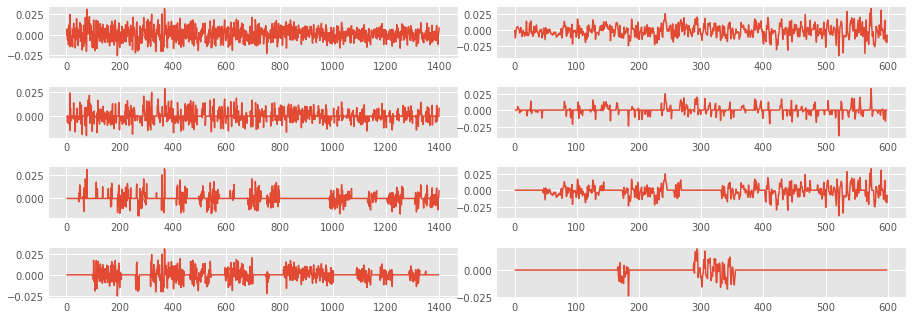

In [570]:
fig, axes = plt.subplots(4,2, figsize=(12.6,4.6))
plt.rcParams['lines.linewidth'] = 1.5
fig.tight_layout()
axes[0][0].plot(returns_bh_train)
axes[1][0].plot(returns_tf_train)
axes[2][0].plot(returns_mr_train)
axes[3][0].plot(returns_dma_train)
axes[0][1].plot(returns_bh_test)
axes[1][1].plot(returns_tf_test)
axes[2][1].plot(returns_mr_test)
axes[3][1].plot(returns_dma_test)

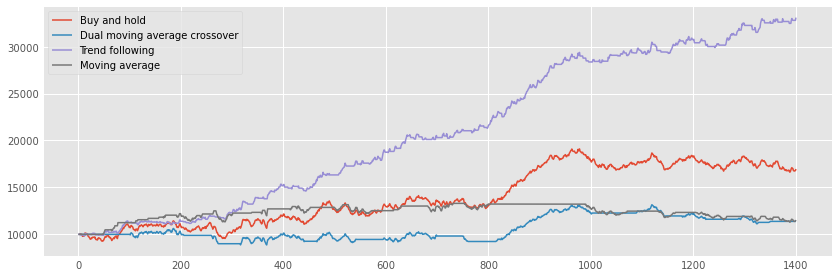

In [572]:
plt.figure(figsize=(12.6,4.6))
t=np.linspace(0,len(X_train),len(X_train))
plt.plot(t, TV_bh[:1400], label="Buy and hold")
plt.plot(t, dma_train, label="Dual moving average crossover")
plt.plot(t, tf_train, label="Trend following")
plt.plot(t, mr_train, label="Moving average")
plt.legend()

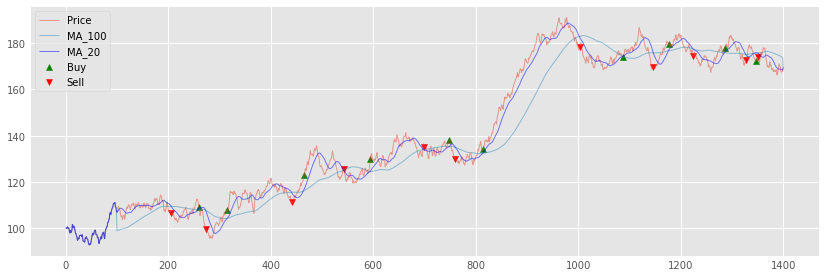

In [573]:
%matplotlib inline
plt.figure(figsize=(12.6,4.6))
plt.plot(t, X_train, alpha=0.5, label="Price", linewidth=1)
plt.plot(t, long_ma_train, alpha=0.5, label="MA_100", linewidth=1)
plt.plot(t, short_ma_train, alpha=0.5, label="MA_20", linewidth=1, color="blue")
plt.scatter(t,sigPriceBuy_train, marker = '^', label = 'Buy', color='green')
plt.scatter(t, sigPriceSell_train, marker = 'v', label = 'Sell',  color='red')
plt.legend()

<ipython-input-362-d096bcffe649>:4: RuntimeWarning: invalid value encountered in log
  r = np.log(TV[i]/TV[i-1])


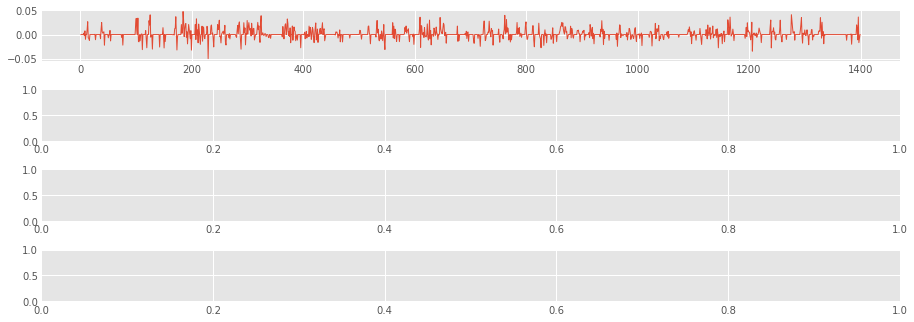

In [332]:
%matplotlib inline
fig, ax = plt.subplots(4,1, figsize = (12.6,4.6))
fig.tight_layout()
ax[0].plot(t, returns_tf, linewidth = 1)

## Strategy 4: ARIMA model

Since my model does not display any obvious trend or seasonal affects, it is easy to see why any potential forecast would simply give a straight line prediction.  

In [298]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

In [299]:
y_train, y_test = y_t[:1400], y_t[len(y_t) - 600:]
model = pm.auto_arima(y_train, m=6, seasonal=True)
forecasts = model.predict(y_test.shape[0])

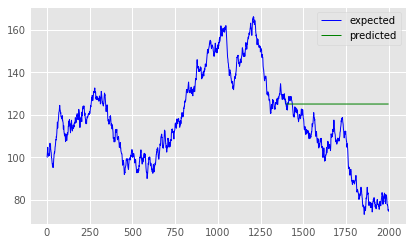

In [300]:
x=np.arange(y_t.shape[0])
plt.plot(x, y_t, c='blue', label='expected', linewidth = 1)
plt.plot(x[1400:],forecasts, c='green', label='predicted', linewidth = 1)
plt.legend()

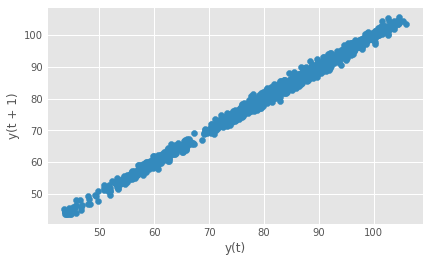

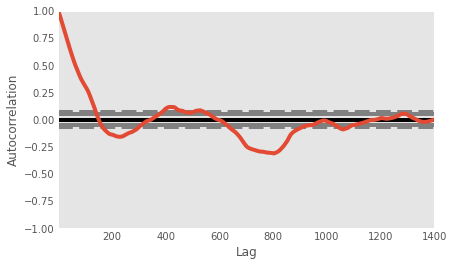

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

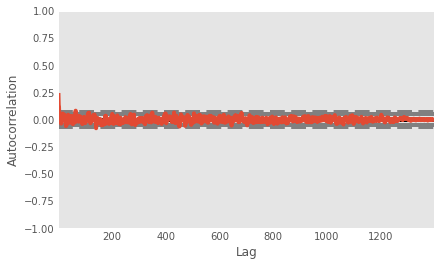

In [301]:
import pandas as pd
from pandas.plotting import lag_plot, autocorrelation_plot

%matplotlib inline
lag_plot(pd.DataFrame(X_train))
plt.show()

autocorrelation_plot(X_train)
plt.show()

autocorrelation_plot(np.diff(np.log(X_train)))

In [302]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(X_train, order=(1,1,0))

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1400
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2033.480
Date:                Wed, 17 Mar 2021   AIC                           4070.960
Time:                        10:20:22   BIC                           4081.447
Sample:                             0   HQIC                          4074.880
                               - 1400                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2390      0.025      9.496      0.000       0.190       0.288
sigma2         1.0716      0.040     26.557      0.000       0.992       1.151
Ljung-Box (L1) (Q):                   0.50   Jarque-

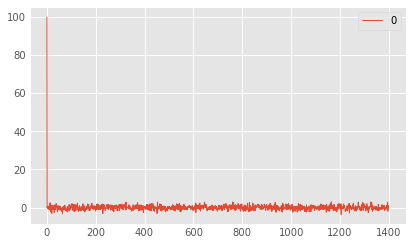

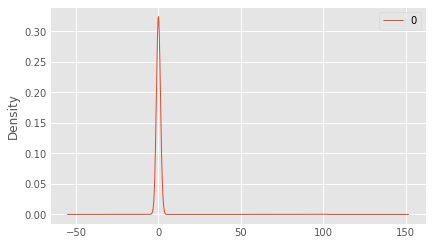

                 0
count  1400.000000
mean      0.057464
std       2.866397
min      -3.577544
25%      -0.708692
50%      -0.017691
75%       0.670210
max     100.000000


In [303]:
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(linewidth=1)
plt.show()
# density plot of residuals
residuals.plot(kind='kde', linewidth = 1)
plt.show()
# summary stats of residuals
print(residuals.describe())

C:\Users\yamin\miniconda3\envs\msc\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[125.24095545 125.21073892 125.26406364 125.21200235 125.08533266
 125.02525991 124.92474313 124.96675811 125.01466703 125.10090999
 124.97701886 125.00316033 124.9477321  124.91055061 124.88159452
 124.81118339 124.72602096 124.65557394 124.6897733  124.76956346
 124.73223899 124.81022361 124.76251775 124.74999393 124.77148902
 124.74166097 124.67228886 124.60174351 124.57212032 124.60108398
 124.59541013 124.69175359 124.65933108 124.67017611 124.70628172
 124.70365223 124.68051961 124.6402465  124.57285517 124.55307379
 124.53286805 124.60861332 124.58879839 124.61905444 124.64900917
 124.6579113  124.67672927 124.67850652 124.61732625 124.58254377
 124.53469592 124.567626   124.54667377 124.58312832 124.59879167
 124.60843036 124.6454733  124.67725713 124.64908424 124.63490457
 124.57623781 124.57237451 124.53953973 124.56582381 124.56507301
 124.57047004 124.60198894 124.64057169 124.64419973 124.66518148
 124.62058682 124.60565372 124.56358128 124.57137912 124.55526363
 124.55487

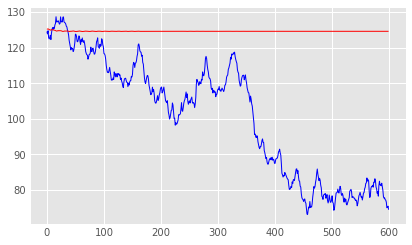

In [304]:
from math import sqrt
from sklearn.metrics import mean_squared_error

X = y_t
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
model = ARIMA(history, order=(10,1,20))
model_fit = model.fit()
output = model_fit.predict(start=1401, end=2000, dynamic=False)
print(output)
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, output))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test, c = 'blue', linewidth = 1)
plt.plot(output, color='red', linewidth=1)
plt.show()

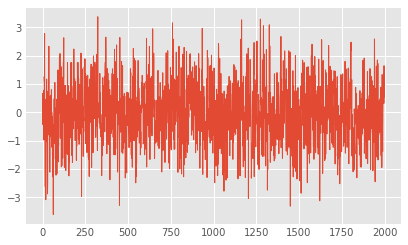

In [261]:
plt.plot(np.diff(y_t), linewidth=1)

# Performance Indicators

I will compute the Sharpe Ratio, Value at Risk (VaR) and the conditional sharpe ratio for each of our strategies.  

### Sharpe Ratio

In [602]:
#Train

sharpe_bh_train = sharpe_ratio(returns_bh_train)
sharpe_tf_train = sharpe_ratio(returns_tf_train)
sharpe_mr_train = sharpe_ratio(returns_mr_train)
sharpe_dma_train = sharpe_ratio(returns_dma_train)

#Test

sharpe_bh_test = sharpe_ratio(returns_bh_test)
sharpe_tf_test = sharpe_ratio(returns_tf_test)
sharpe_mr_test = sharpe_ratio(returns_mr_test)
sharpe_dma_test = sharpe_ratio(returns_dma_test)


In [603]:
sharpe_train = [sharpe_bh_train, sharpe_tf_train, sharpe_mr_train, sharpe_dma_train]
sharpe_test = [sharpe_bh_test, sharpe_tf_test, sharpe_mr_test, sharpe_dma_test]
df = pd.DataFrame()
df['sharpe_train'] = sharpe_train
df['sharpe_test'] = sharpe_test
df['strategy'] = ["buy and hold", "trend following", "mean reversion", "dual moving avg"]

### VaR

In [604]:
def vaR(data):
    df = pd.DataFrame()
    df['returns'] = data
    df.sort_values('returns',inplace = True, ascending = True)
    VaR_95 = df['returns'].quantile(0.05)

    #plt.hist(df.returns, bins = 40)
    #plt.axvline(x=VaR_95,color='b')

    #plt.xlabel('Returns')
    #plt.ylabel('Frequency')
    #plt.s(how)


    return VaR_95

In [605]:
# Train
vaR_bh_train = vaR(returns_bh_train)
vaR_mr_train = vaR(returns_mr_train)
vaR_tf_train = vaR(returns_tf_train)
vaR_dma_train = vaR(returns_dma_train)

# Test 
vaR_bh_test = vaR(returns_bh_test)
vaR_mr_test = vaR(returns_mr_test)
vaR_tf_test = vaR(returns_tf_test)
vaR_dma_test = vaR(returns_dma_test)

vaR_train = [vaR_bh_train, vaR_tf_train, vaR_mr_train, vaR_dma_train]
vaR_test = [vaR_bh_test, vaR_tf_test, vaR_mr_test, vaR_dma_test]
df['vaR_train'] = vaR_train
df['vaR_test'] = vaR_test

### Excess Shortfall

In [606]:
def csr(data):
    data = np.array(data)
    avg_returns = data.mean()
    df = pd.DataFrame()
    df['returns'] = data
    df.sort_values('returns',inplace = True, ascending = True)
    VaR_95 = df['returns'].quantile(0.05)
    excess = df[df['returns'] <= VaR_95]
    excess_shortfall = excess.mean()
    conditional_sharp = avg_returns*np.sqrt(252)/excess_shortfall
    return conditional_sharp[0]

In [607]:
# Train

csr_bh_train = csr(returns_bh_train)
csr_tf_train = csr(returns_tf_train)
csr_mr_train = csr(returns_mr_train)
csr_dma_train = csr(returns_dma_train)

# Test

csr_bh_test = csr(returns_bh_test)
csr_tf_test = csr(returns_tf_test)
csr_mr_test = csr(returns_mr_test)
csr_dma_test = csr(returns_dma_test)

csr_train = [csr_bh_train, csr_tf_train, csr_mr_train, csr_dma_train]
csr_test = [csr_bh_test, csr_tf_test, csr_mr_test, csr_dma_test]
df['csr_train'] = csr_train
df['csr_test'] = csr_test
df.set_index('strategy')

,sharpe_train,sharpe_test,vaR_train,vaR_test,csr_train,csr_test
strategy,,,,,,
buy and hold,0.776224,-2.391585,-0.012450,-0.016351,-0.384151,1.005533
trend following,2.524512,0.699843,-0.007991,-0.010249,-1.156576,-0.278046
mean reversion,0.330440,-2.339440,-0.008224,-0.014390,-0.137055,0.907863
dual moving avg,0.250762,-0.749035,-0.009736,-0.005774,-0.104863,0.242567


# Statistical Tests

In [608]:
from scipy.stats import t
degrees_f = 251
p_values_train = []
p_values_test = []
for sh in sharpe_train:
    p = 1-t.cdf(sh,degrees_f)
    p_values_train.append(p)

for sh in sharpe_test:
    p = 1-t.cdf(sh,degrees_f)
    p_values_test.append(p)

In [610]:
print(p_values_train)
print(p_values_test)

[0.21917363078525898, 0.006101632399259649, 0.37067147085827845, 0.40110151641027936]
[0.9912436382441551, 0.24233658277715175, 0.9899512680240468, 0.7727312583125936]
